# Probabilistic models for count data

This notebook gives an overview of basic statistical notions behind probabilistic count models

* [Richard McElreath. Statistical Rethinking. Chapters 10 -- 11](https://xcelab.net/rm/statistical-rethinking/)
* [Yufeng. Diagnose the Generalized Linear Models](https://towardsdatascience.com/diagnose-the-generalized-linear-models-66ad01128261)
* [Norman E. Breslow. Generalized linear models: Checking assumptions and strengthening conclusions](http://sa-ijas.stat.unipd.it/sites/sa-ijas.stat.unipd.it/files/23-41_2.pdf)
* [Daryl Pregibon. Goodness of Link Tests for Generalized Linear Models](https://www.jstor.org/stable/2346405#metadata_info_tab_contents)
* [Marlene Müller. Generalized Linear Models](http://www.marlenemueller.de/publications/HandbookCS.pdf)

<center><h1>Probabilistic models for count data</h1> </center>
<center><h2>Generalised Linear Models</h2></center>
<br>
<center><h3>Sven Laur</h3></center>
<center><h3>swen@ut.ee</h3></center>

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions 

from pandas import DataFrame
from plotnine import *

## Main framework for defining probabilistic models
<br>
<center><img src="./illustrations/tfp_framework.png" alt="Tensorflow Probability" width="700"><center>

## Statistical rethinking of the model components

<br>
<center><img src="./illustrations/alternative_model_decomposition.png" alt="Alternative decomposition" width="800"><center>
    
We can **typically** split the standard Tensorflow Probability model into two components:

* Neural network for automatic feature engineering.   

* Generalised linear model for mapping top-level features to probability distributions.
    
Such decomposition is always possible whenever the parameters of the distribution are computed as an outcome of individual neurons.    
    
For many models this decomposition is quite revealing and allows to describe the model in standard terms of statistics.    
    

In [26]:
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [31]:
# Define top-level features
inputs = tf.keras.Input(shape=(10,), dtype=tf.float32)
low_level_features = layers.Dense(units=40)(inputs) 
top_level_features = layers.Dense(units=20)(inputs) 

# Find parameters for the distribution
inverse_link_function = tf.exp
parameters = layers.Dense(1, activation=inverse_link_function)(top_level_features)

# Declare the output distribution
distribution_family = tfd.Poisson
output_distribution = tfp.layers.DistributionLambda(distribution_family)(parameters)

model = tf.keras.Model(name='example_model', inputs=inputs, outputs=output_distribution)

# Define negative log-likelihood as a loss and choose a parameter optimiser
def NLL(y_true, y_hat):
    return -y_hat.log_prob(y_true)

model.compile(Adam(learning_rate=0.01), loss=NLL)
model.summary()

Model: "example_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_31 (Dense)            (None, 20)                220       
                                                                 
 dense_32 (Dense)            (None, 1)                 21        
                                                                 
 distribution_lambda_9 (Dist  ((None, 1),              0         
 ributionLambda)              (None, 1))                         
                                                                 
Total params: 241
Trainable params: 241
Non-trainable params: 0
_________________________________________________________________


## Formal definition of Generalised Linear Model

Generalised linear model connects the input $\boldsymbol{x}$ with the distribution for the output $y$ by the following template   

\begin{align*}
&y\sim Distribution(\theta_1,\ldots,\theta_k)\\
& \\
&f_1(\theta_1)= \boldsymbol{\beta}_1^T \boldsymbol{x}\\
&\ldots\\
&f_k(\theta_k)= \boldsymbol{\beta}_k^T \boldsymbol{x}\\
\end{align*}

where one can choose 

* a parametrised of **probability distribution** $Distribution(\theta_1,\ldots,\theta_k)$
* **link functions** $f_1,\ldots,f_k:\mathbb{R}\to\mathbb{R}$ to connect parameters with linear combinations inputs $\boldsymbol{\beta}_1^T \boldsymbol{x},\ldots, \boldsymbol{\beta}_k^T \boldsymbol{x}$ 

Parameter vectors $\boldsymbol{\beta}_1,\ldots, \boldsymbol{\beta}_k$ or their posterior distribution must be inferred from the data.  

**Bayesian rethinking**

* True Bayesian approach requires also **priors** for parameter vectors $\boldsymbol{\beta}_1,\ldots, \boldsymbol{\beta}_k$. The latter is a non-trivial task.  

* In the framework of Tensorflow Probability the priors manifest as regularisation term in the loss function.  

## The main goal of link functions

The GLM layer in a neural network implements **inverse link function**. Most common link functions are
* **logit link function** that corresponds to a softmax layer;
* **log link function** that corresponds to exponent nodes. 

The aim of the inverse link function is to compress the output range of a linear combination into the range of the parameter.   

The exact mapping determines the convergence properties of the model and stability of prediction intervals.

Statisticians have studied this problem a lot and have established which link functions are good for particular parametrisations of distributions. 

Link functions make it hard to interpret the parameters $\boldsymbol{\beta}_1,\ldots\boldsymbol{\beta}_k$ as the same change of $\boldsymbol{\beta}_1^T\boldsymbol{x}$ can have vastly different impact to the output distribution.  

## Unexpected troubles with Generalised Linear Models

Inner workings of Generalised Linear Models are much harder to interpret and control than ordinary linear regression.      

<br>
<center>
    <img src="./illustrations/cog_machine.png" alt="GLM as a cog machine" width="800">
<center>



## Binomial distribution as an output distribution

Binomial distribution is adequate when the outcome is a sum of independent trials:
* binary classification task 
* binary outcome of a single trial 
* number of defects in a single batch

It is crucial that you know the number of independent trials for each observation.

Binomial distribution is determined by the number of trials and a success probability of an individual trial. 

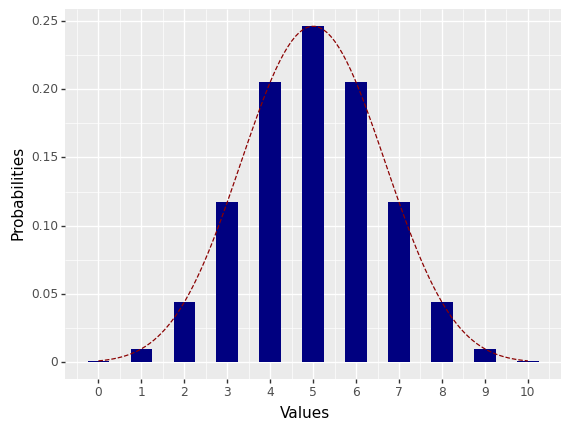

<ggplot: (402379846)>

In [32]:
dist = tfd.binomial.Binomial(total_count=10, probs=0.5) # logits=0

pm = DataFrame({'x': np.linspace(0,10,11)}).assign(p = lambda df: dist.prob(df['x']))
fd = DataFrame({'x': np.linspace(0,10,110)}).assign(p = lambda df: dist.prob(df['x']))

p = ggplot(pm) 
p += geom_col(aes(x='x', y='p'), fill='navy', width=0.5)
p += geom_line(aes(x='x', y='p'), data=fd, color='darkred', linetype='dashed')
p += xlab('Values') + ylab('Probabilities')
p += scale_x_continuous(breaks=range(0, 21))
display(p)

## Corresponding inverse link functions

Different link functions have different sensitivity properties -- in different regions changes in inputs have different effect on the success probability.   

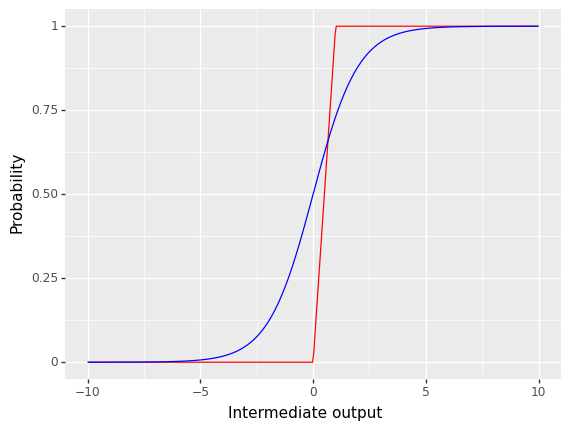

<ggplot: (397768954)>

In [3]:
df = (DataFrame({'x': np.linspace(-10,10,400)})
      .assign(g1=lambda df: df['x'].clip(lower=0, upper=1))
      .assign(g2=lambda df:1/(1 + np.exp(-df['x']))))

p = ggplot(df) 
p += geom_line(aes(x='x', y='g1'), color='red')
p += geom_line(aes(x='x', y='g2'), color='blue')
p += xlab('Intermediate output') + ylab('Probability')
display(p)

## Curious sequence of binomial distributions 

What if we do not know the number individual trials but know the expected number of successful trials $\lambda$ in fixed time interval? 

As the expected number of successful trials is $\lambda=Np$, we can compute probability distributions for different values of trials $N$. 

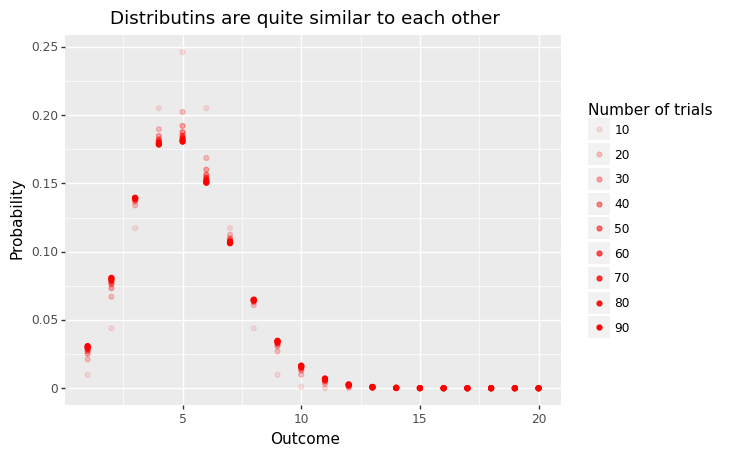

<ggplot: (276282365)>

In [4]:
L = 5.0
N = list(range(10, 100, 10))
X = list(range(1,21))

pm = pd.concat([DataFrame({
        'N': n,
        'x': X, 
        'pr':tfd.binomial.Binomial(total_count=n, probs=L/n).prob(X)}) for n in N])

p = ggplot(pm) 
p += geom_point(aes(x='x', y='pr', alpha = 'N'), fill='red', color='red')
p += scale_alpha_continuous(name = 'Number of trials', breaks=N)
p += ggtitle('Distributins are quite similar to each other')
p += xlab('Outcome') + ylab('Probability')  
display(p)

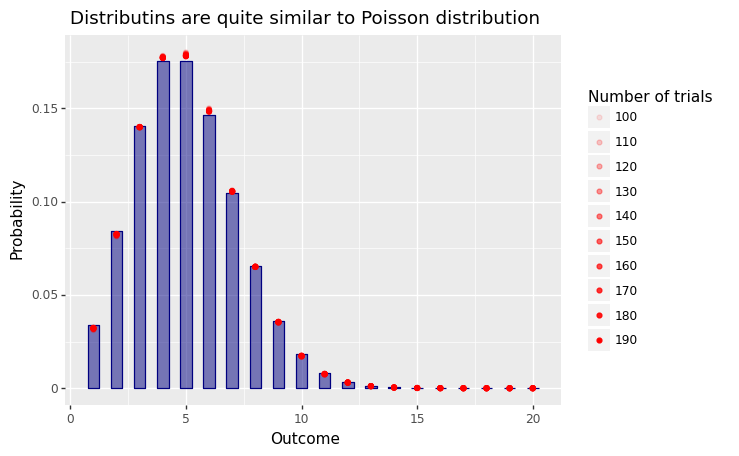

<ggplot: (397878122)>

In [5]:
L = 5.0
N = list(range(100, 200, 10))
X = list(range(1,21))

pm = pd.concat([DataFrame({
        'N': n,
        'x': X, 
        'pr':tfd.binomial.Binomial(total_count=n, probs=L/n).prob(X)}) for n in N])

plimit = DataFrame({'x': X, 'pr':tfd.poisson.Poisson(rate=L).prob(X)})

p = ggplot(pm) 
p += geom_col(aes(x='x', y='pr'), width=0.5, color='navy', fill='navy', alpha=0.5, data=plimit)
p += geom_point(aes(x='x', y='pr', alpha = 'N'), fill='red', color='red')
p += scale_alpha_continuous(name = 'Number of trials', breaks=N)
p += ggtitle('Distributins are quite similar to Poisson distribution')
p += xlab('Outcome') + ylab('Probability')  
display(p)

## Poisson distribution 

Poisson distribution is appropriate if 
* the outcome is sum of unknown trials for each data point;
* the number is trials is roughly the same for each data point; 
* the unknown number of trials is quite large. 

Typical examples are 
* number of birds observed in a day,
* number of errors in a batch with unknown size, 
* number of deers per square km. 

The corresponding link function is usually $\log(\cdot)$ and the inverse link function $\exp(\cdot)$.

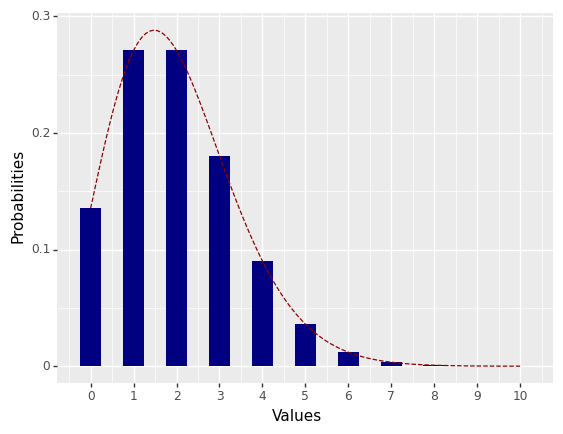

<ggplot: (402384535)>

In [33]:
dist = tfd.poisson.Poisson(rate=2)

pm = DataFrame({'x': np.linspace(0,10,11)}).assign(p = lambda df: dist.prob(df['x']))
fd = DataFrame({'x': np.linspace(0,10,110)}).assign(p = lambda df: dist.prob(df['x']))

p = ggplot(pm) 
p += geom_col(aes(x='x', y='p'), fill='navy', width=0.5)
p += geom_line(aes(x='x', y='p'), data=fd, color='darkred', linetype='dashed')
p += xlab('Values') + ylab('Probabilities')
p += scale_x_continuous(breaks=range(0, 11))
display(p)

## Zero Inflated Poisson distribution 

* Often zero is overrepresented in observations compared to the best fit with a Poisson distribution.
* There is a separate process that generates zero observations we must include to the model.
* We can implement this distribution using `Mixture` constuction.    

<center><img src="./illustrations/zero_inflated_poisson.png" alt="Zero-inflated Poisson" width="400"><center>
    


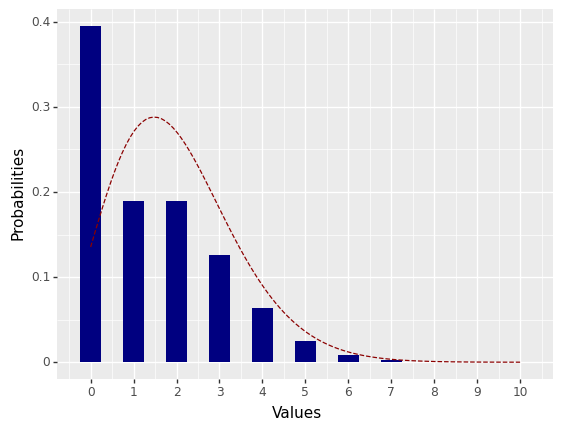

<ggplot: (402438690)>

In [34]:
pi = 0.3
L = 2 

ZIP = tfd.Mixture(
    cat = tfd.Categorical(probs=[pi, 1 - pi]),
    components = [tfd.Deterministic(loc=0), tfd.Poisson(rate=L)]
)

pm = DataFrame({'x': np.linspace(0,10,11)}).assign(p = lambda df: ZIP.prob(df['x']))
fd = DataFrame({'x': np.linspace(0,10,110)}).assign(p = lambda df: tfd.Poisson(rate=L).prob(df['x']))

p = ggplot(pm) 
p += geom_col(aes(x='x', y='p'), fill='navy', width=0.5)
p += geom_line(aes(x='x', y='p'), data=fd, color='darkred', linetype='dashed')
p += xlab('Values') + ylab('Probabilities')
p += scale_x_continuous(breaks=range(0, 11))
display(p)

## Poisson distribution for different exposures

Sometimes different data points correspond to different time intervals $\tau$ and we need to compensate for it.
* We still assume that our model can predict the rate $\lambda$ per time unit.
* We need to compute the expected rate $\mu$ for the interval $\tau$. 

If we use log link function then obviously

\begin{align*}
 \log \lambda_i=\log \frac{\mu_i}{\tau_i}=\boldsymbol{\beta}^T\boldsymbol{x}
\end{align*}

and consequently

\begin{align*}
\log \mu_i= \log \tau_i + \boldsymbol{\beta}^T\boldsymbol{x} \qquad\Longleftrightarrow\qquad
\mu_i=\tau_i\cdot \exp(\boldsymbol{\beta}^T\boldsymbol{x})
\end{align*}

Thus we must treat the exposure $\tau_i$ as a separate input feature for each data point that 
* is not used in the neural network model;
* is used as multiplicative constant for finding the correct range.

In [40]:
# Define top-level features
glm_inputs = tf.keras.Input(shape=(10,), dtype=tf.float32)
exposure_times = tf.keras.Input(shape=(1,), dtype=tf.float32)

# Find parameters for the distribution
parameters = tf.multiply(exposure_times, layers.Dense(1, activation=tf.exp)(top_level_features))

# Declare the output distribution
distribution_family = tfd.Poisson
output_distribution = tfp.layers.DistributionLambda(distribution_family)(parameters)

model = tf.keras.Model(name='poisson_model_with_different_exposures', inputs=[inputs, exposure_times], outputs=output_distribution)
model.summary()

Model: "poisson_model_with_different_exposures"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 dense_31 (Dense)               (None, 20)           220         ['input_13[0][0]']               
                                                                                                  
 input_23 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 dense_37 (Dense)               (None, 1)            21          ['dense_31[0][0]']               
                                                             

## Negative binomial distribution 

The variance of Poisson distribution is fixed by the rate $\lambda$. Sometimes you want to have a model where the variance can be changed independently of the rate. This can be modelled as complex sampling process 

\begin{align*}
\lambda_*&\sim\Gamma(\alpha, \beta)\\
y&\sim Poisson(\lambda_*)
\end{align*}

where $\alpha$ and $\beta$ parameters are chosen so that the expected value is $\lambda$. This poses a restriction $\alpha\beta=\lambda$ and thus we can re-parametrise the distribution by specifying $\lambda, \beta$. Then the corresponding formula for the variance is $\lambda+\lambda^2/\beta$.

By sheer luck this distribution is equivalent to negative binomial distribution that is defined by a process where one counts how many failures occurs in Bernoulli trials before getting $r$ successes given that the success probability is $p$.  


The latter is useful for certain modelling tasks. In particular, we can estimate how many calls a sales representative must do before securing $r$ sales. But the ability to adjust the variance is more common reason to use this distribution.


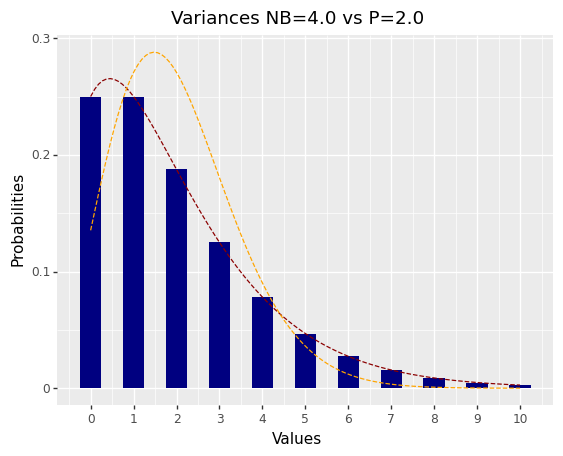

<ggplot: (697324713)>

In [41]:
dist = tfd.NegativeBinomial(total_count=2, probs=0.5)

pm = DataFrame({'x': np.linspace(0,10,11)}).assign(p = lambda df: dist.prob(df['x']))
fd = DataFrame({'x': np.linspace(0,10,110)}).assign(p = lambda df: dist.prob(df['x']))
pd = DataFrame({'x': np.linspace(0,10,110)}).assign(p = lambda df: tfd.Poisson(dist.mean()).prob(df['x']))

p = ggplot(pm) 
p += geom_col(aes(x='x', y='p'), fill='navy', width=0.5)
p += geom_line(aes(x='x', y='p'), data=fd, color='darkred', linetype='dashed')
p += geom_line(aes(x='x', y='p'), data=pd, color='orange', linetype='dashed')
p += xlab('Values') + ylab('Probabilities')
p += ggtitle(f'Variances NB={dist.variance():.4} vs P={dist.mean():.4}')
p += scale_x_continuous(breaks=range(0, 11))
display(p)